<center>
<div class="h1">Info 114: Introduction to Data Science</div>
<div class="h1">Homework 3: from VI-ME-BA-BAR to POM</div>
</center>

# Part 3: Project selection
You will find below some code that was written to prepare the class.
We will go more in depth over these questions in later classes.
This is a "preview" to help you select your project.

Our problem seems rather complex. Non-linear methods perform best.
Unfortunately, these methods are hard to understand.
To make progress, we must try to visualize our data again.

In this worksheet, we use as example the data of `CS_data.csv`, after standardization.

## Setup: import code an load data

In [55]:
import os, re
from glob import glob as ls
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from PIL import Image
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
code_dir = './code'
from sys import path; path.append(code_dir); 
from utilities import *
from my_utilities import *

In [58]:
data_dir = './mini-dataset/'
data_df = standardize_df(pd.read_csv(data_dir + 'CS_data.csv'))

## Heatmap

Since it is very important to visualize data, we show below a heatmap of the data in which the lignes and columns have been re-arranged according to their resemblance. This is an "unsupervised learning" visualization method, so we omit the last column.

In [59]:
data_df.head()

,R,G,B,M=maxRGB,m=minRGB,C=M-m,R-(G+B)/2,G-B,G-(R+B)/2,B-R,...,(G-B)/C,(B-R)/C,(R-G)/C,(R+G+B)/3,C/V,W,H,W/H,W*H,fruit
0,-0.094697,-0.802912,1.418747,-0.891020,1.336466,-1.696950,-0.432637,-1.660362,-1.347004,1.210587,...,-2.336012,0.646130,1.179120,0.326008,-1.650431,0.249030,0.065306,-0.126039,-0.032573,1.0
1,0.503616,-0.772561,-0.666665,0.183203,-0.913998,0.879247,1.148003,-0.029340,-0.573507,-0.898534,...,-0.629588,-0.462186,0.866252,-0.499504,0.938614,0.278258,-0.273339,0.449690,-0.190080,1.0
2,0.061006,-1.398826,-2.104806,-0.741563,-2.119769,1.269262,1.765190,0.639794,-0.241299,-1.738912,...,-0.096683,-0.983712,0.919732,-1.801489,1.726784,2.273420,1.076728,0.157238,1.436246,1.0
3,-1.726425,0.099504,-0.595447,-0.333516,-0.686620,0.349539,-1.302076,0.529659,1.114701,0.760168,...,0.582662,1.098479,-1.379813,-1.107018,0.552259,-0.145793,-0.563028,0.591975,-0.426325,1.0
4,-0.060727,1.399374,1.787878,1.139418,1.806535,-0.746776,-1.604870,-0.394783,0.394178,1.483473,...,0.414910,1.919623,-1.962907,1.630251,-0.909639,-1.142907,-1.194313,1.109809,-0.814331,1.0



Performing hierarchical clustering using euclidean for columns and euclidean for rows
Column clustering completed in 0.0 seconds
Row clustering completed in 0.5 seconds


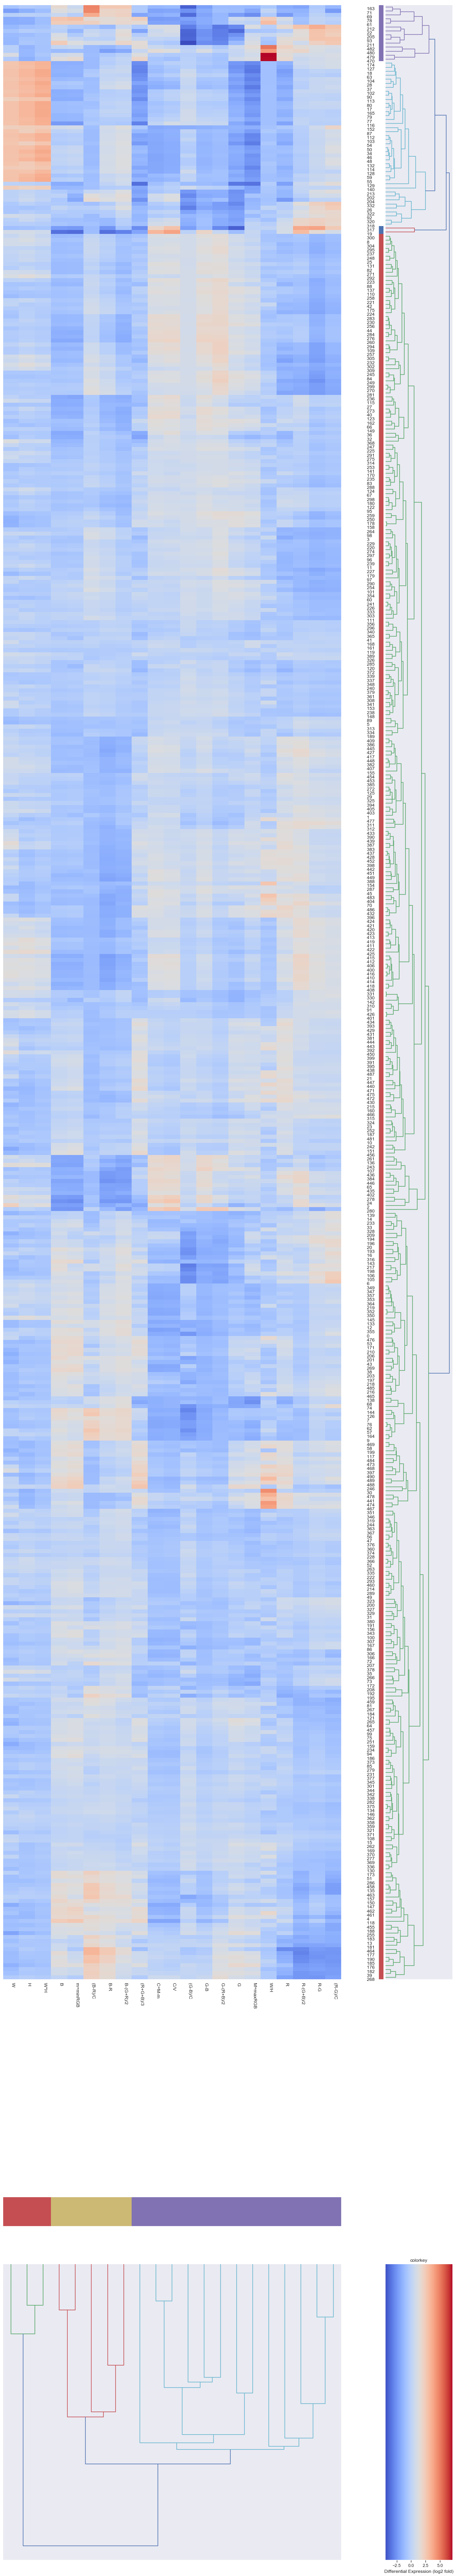

In [60]:
df = data_df.iloc[:, :-1]
heatmap(df, 'average', 'single', 'euclidean', 'euclidean', 'coolwarm')

For comparison, we show what happens if we randomize completely the order of the values.


Performing hierarchical clustering using euclidean for columns and euclidean for rows
Column clustering completed in 0.0 seconds
Row clustering completed in 0.5 seconds


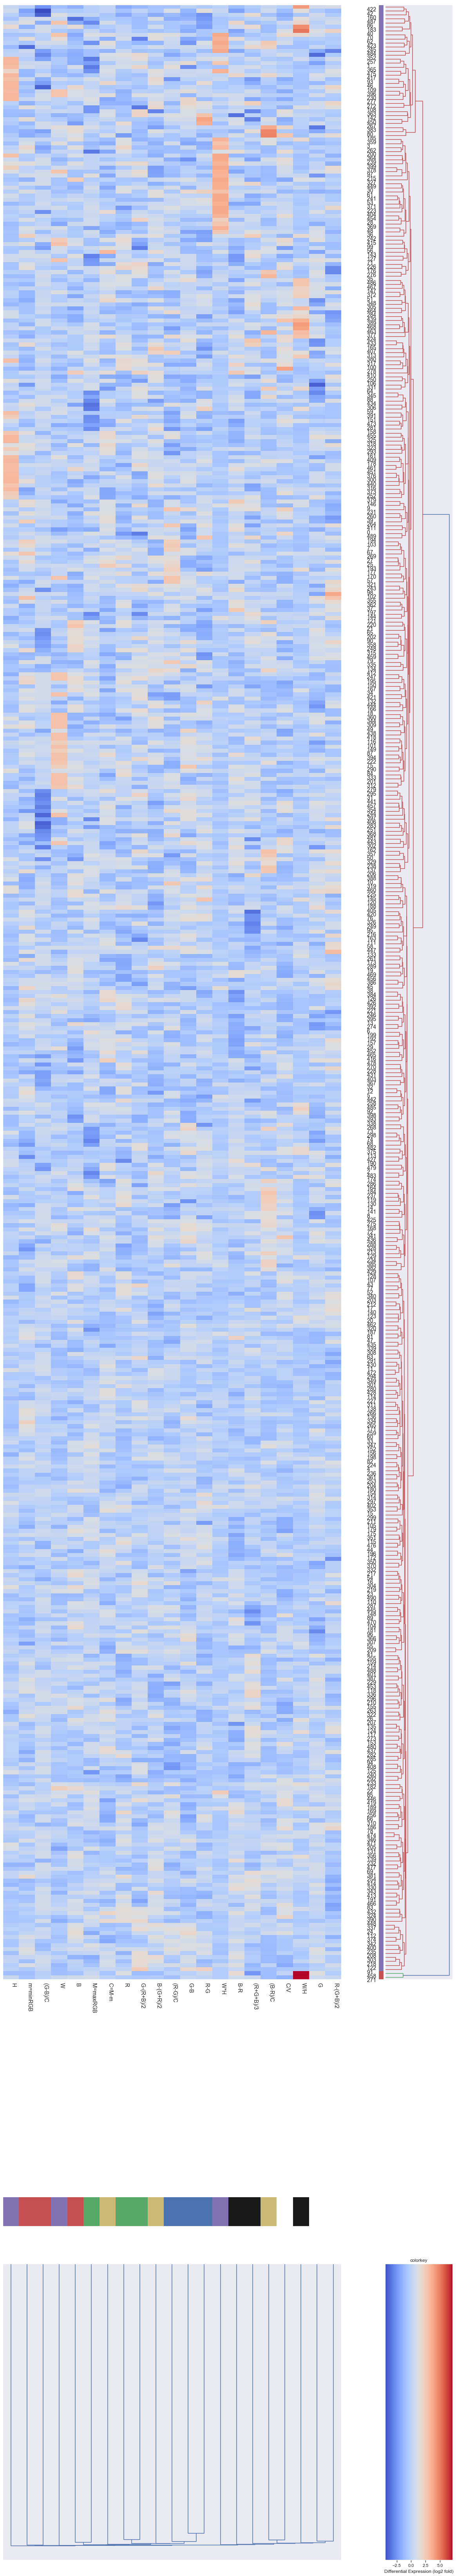

In [14]:
df2 = shuffle(df)
heatmap(df2, 'average', 'single', 'euclidean', 'euclidean', 'coolwarm')

## Correlation


We display the correlation matrix of `data_df`, following <a href="https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas">this page</a>.

In [15]:
corr = data_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,R,G,B,M=maxRGB,m=minRGB,C=M-m,R-(G+B)/2,G-B,G-(R+B)/2,B-R,B-(G+R)/2,R-G,(G-B)/C,(B-R)/C,(R-G)/C,(R+G+B)/3,C/V,W,H,W/H,W*H,fruit
R,1,0.230917,0.141989,0.568864,0.202103,0.207796,0.723708,0.0529786,-0.294698,-0.603729,-0.359215,0.608775,-0.0826116,-0.575745,0.55764,0.67387,0.0947257,-0.210559,-0.402192,0.471636,-0.348155,-0.476703
G,0.230917,1,0.0841397,0.800924,0.165289,0.391509,-0.295664,0.639096,0.73833,-0.0980551,-0.416924,-0.631325,0.618388,0.176843,-0.611987,0.651075,0.273112,-0.403539,-0.483486,0.25564,-0.490145,-0.143687
B,0.141989,0.0841397,1,0.0964816,0.967587,-0.739104,-0.416593,-0.712626,-0.468299,0.70339,0.788702,0.0445683,-0.4437,0.420247,-0.0324783,0.651717,-0.812593,-0.439393,-0.428705,0.208371,-0.381748,-0.00239503
M=maxRGB,0.568864,0.800924,0.0964816,1,0.11324,0.566092,0.0948042,0.489412,0.41261,-0.330789,-0.458653,-0.199638,0.238917,0.0290046,-0.202554,0.72261,0.440219,-0.540955,-0.643551,0.346845,-0.656552,-0.187213
m=minRGB,0.202103,0.165289,0.967587,0.11324,1,-0.754935,-0.383412,-0.630476,-0.407254,0.63412,0.704223,0.0263152,-0.282308,0.289676,-0.0398773,0.703279,-0.837313,-0.399354,-0.411306,0.250534,-0.35431,-0.062311
C=M-m,0.207796,0.391509,-0.739104,0.566092,-0.754935,1,0.380684,0.846126,0.610231,-0.744451,-0.88701,-0.153603,0.391921,-0.221194,-0.100609,-0.10654,0.985265,-0.0257191,-0.083521,0.0210708,-0.13939,-0.0718711
R-(G+B)/2,0.723708,-0.295664,-0.416593,0.0948042,-0.383412,0.380684,1,0.113394,-0.36962,-0.855183,-0.530639,0.817917,-0.135402,-0.81355,0.80184,-0.0222006,0.37049,0.218525,0.0771373,0.202094,0.105202,-0.362515
G-B,0.0529786,0.639096,-0.712626,0.489412,-0.630476,0.846126,0.113394,1,0.881277,-0.611956,-0.902302,-0.478879,0.777847,-0.199868,-0.405795,-0.0446535,0.819493,0.0550438,-0.00949188,0.0191473,-0.0504246,-0.0993128
G-(R+B)/2,-0.294698,0.73833,-0.468299,0.41261,-0.407254,0.610231,-0.36962,0.881277,1,-0.165527,-0.591438,-0.836911,0.79186,0.20006,-0.760915,-0.0312005,0.590172,-0.0524674,-0.0455687,-0.0782228,-0.0971989,0.0795579
B-R,-0.603729,-0.0980551,0.70339,-0.330789,0.63412,-0.744451,-0.855183,-0.611956,-0.165527,1,0.893126,-0.401256,-0.298012,0.751876,-0.426586,0.0409676,-0.722442,-0.202667,-0.0564515,-0.170861,-0.0574372,0.340382


We can also use the hierarchical clustering.


Performing hierarchical clustering using euclidean for columns and euclidean for rows
Column clustering completed in 0.0 seconds
Row clustering completed in 0.1 seconds


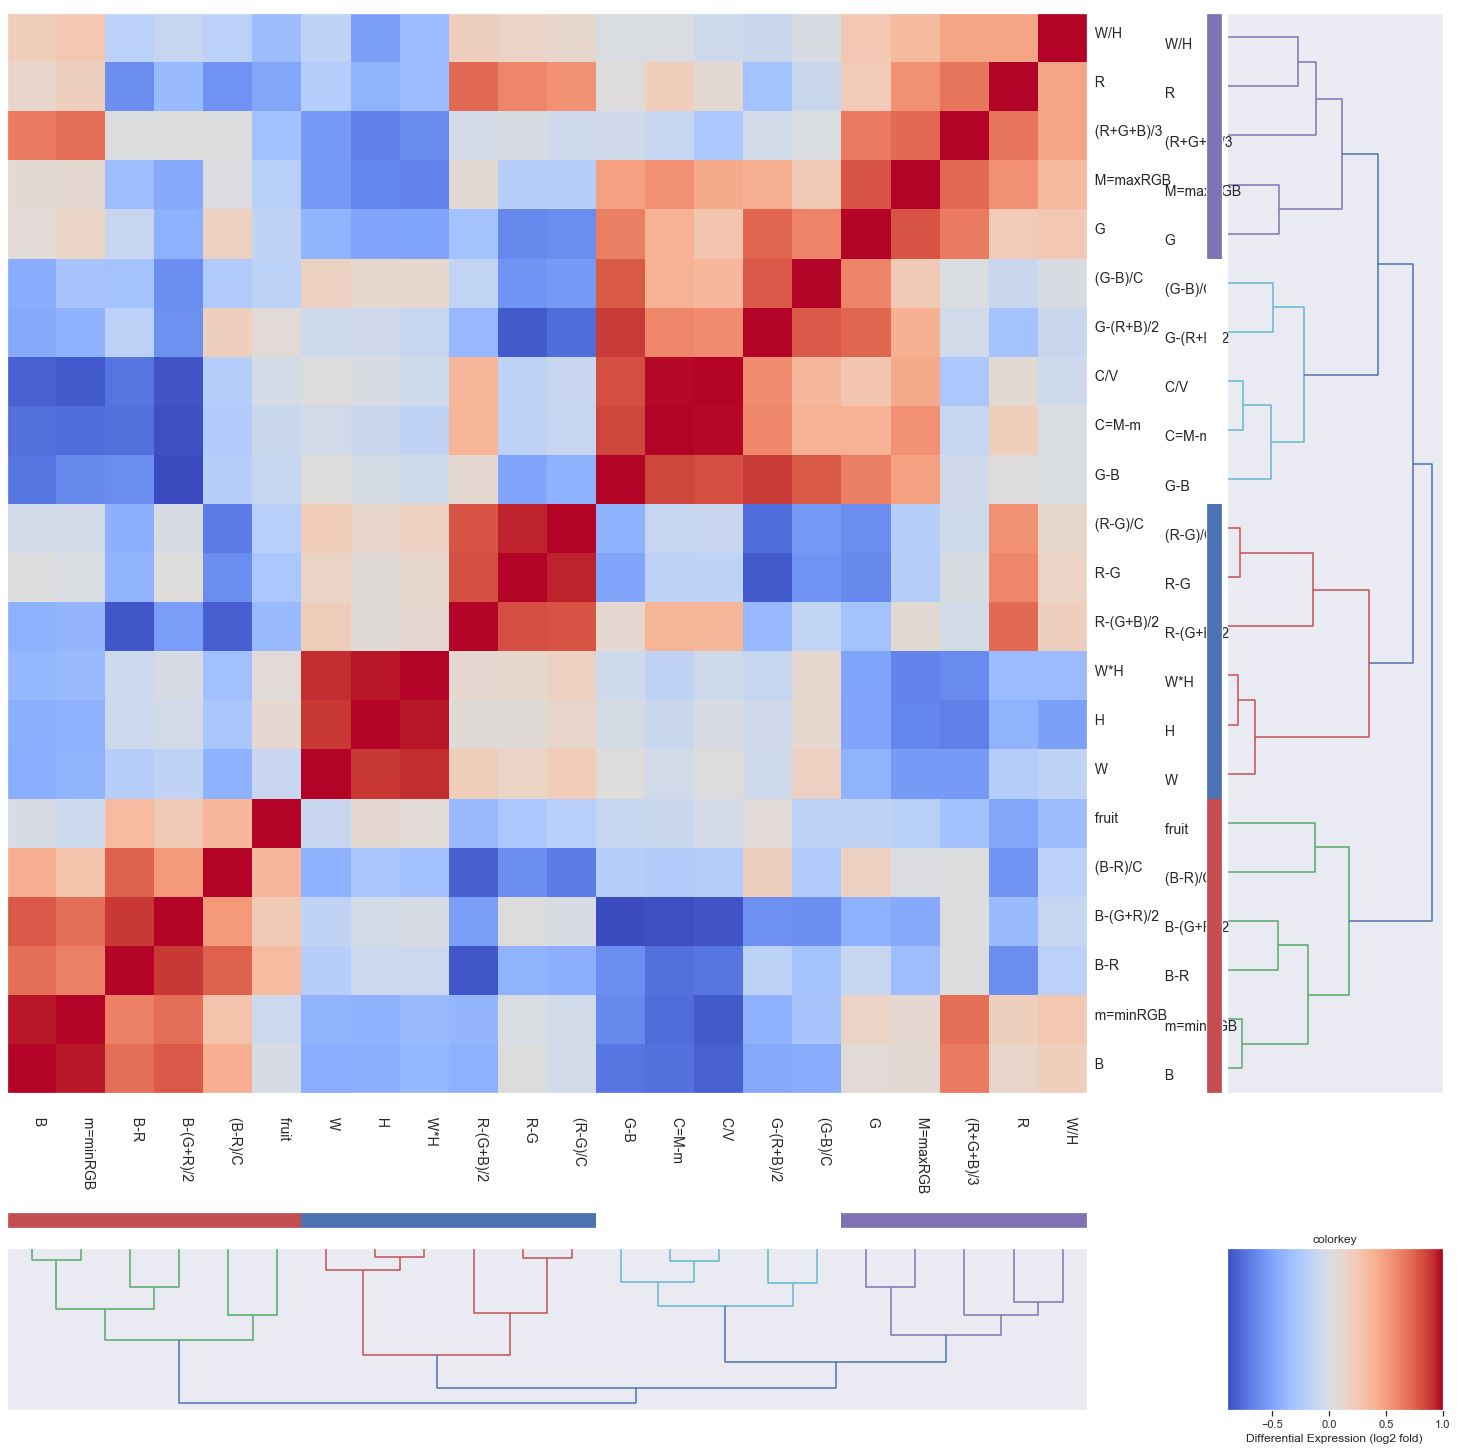

In [16]:
heatmap(corr, 'average', 'average', 'euclidean', 'euclidean', 'coolwarm', default_window_hight = 15, default_window_width = 15)

You can look for the most correlated or anti-correlated feature/variable.

In [17]:
np.fill_diagonal(corr.values, 0)
print('Most correlated: ' + corr.fruit.argmax())
print('Most anti-correlated: ' + corr.fruit.argmin())

Most correlated: (B-R)/C
Most anti-correlated: R


Are you surprised? I was surprised. In the first toy dataset we played with, apples were correlated with red. This is no longer the case. You can check out the dataset and understand why. In this new dataset, most apples are gree. Many bananas are yellow and some are green.

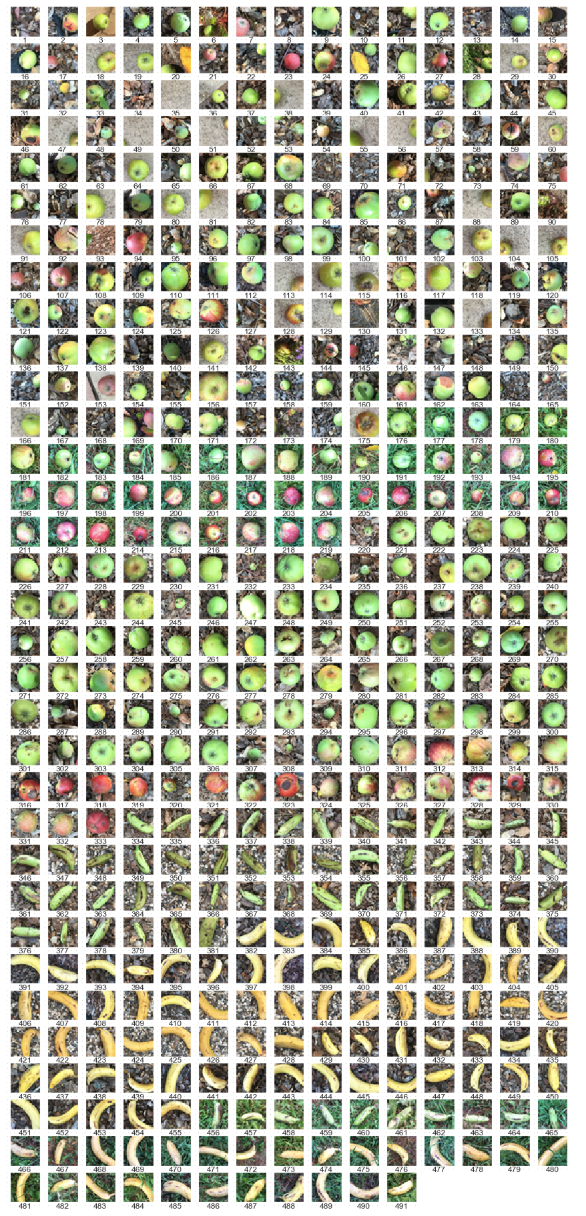

In [18]:
img = get_image(data_dir + 'all_data.png')
img

The dataset is not completely well balanced, so the Pearson correlation coefficient may not be the best way to identify the most informative features. Let's see whether S2N makes a difference.

In [19]:
s2n_coeff = s2n(data_df)
print('Largest s2n: ' + s2n_coeff.feat.argmax())
print('Smallest s2n: ' + s2n_coeff.feat.argmin())

Largest s2n: (B-R)/C
Smallest s2n: R


We get the same features with S2N and the Pearson correlation coefficient.

## Feature selection
We are going to perform some simple-minded feature selection with the Pearson correlation coefficient. This will allow us to do some data visualization.

Let us first sort all features by the absolute value of the Pearson correlation coefficient. Indeed, variables are informative no matter whether they are correlated or anti-correlated (since it suffices to multiply them by -1 to change the correlation direction).

In [20]:
# Sort by correlation coefficient
sval = corr['fruit'][:-1].abs().sort_values(ascending=False)
ranked_columns = sval.index.values
print(ranked_columns) 

['R' '(B-R)/C' 'R-(G+B)/2' 'B-R' 'W/H' '(R+G+B)/3' 'R-G' 'B-(G+R)/2'
 '(R-G)/C' 'M=maxRGB' '(G-B)/C' 'G' 'H' 'G-B' 'W' 'G-(R+B)/2' 'W*H'
 'C=M-m' 'm=minRGB' 'C/V' 'B']


We notice that the features that we had constructed in previous lessons 'R-(G+B)/2' and 'W/H' come in the 5 top most informative features. But there are others. Let us make all scatter plots of pairs of features for the 5 top ranked features.

In [21]:
fruit_name = ['Banana', 'Apple']
fruit_list = [fruit_name[int((i+1)/2)] for i in data_df["fruit"].tolist()]

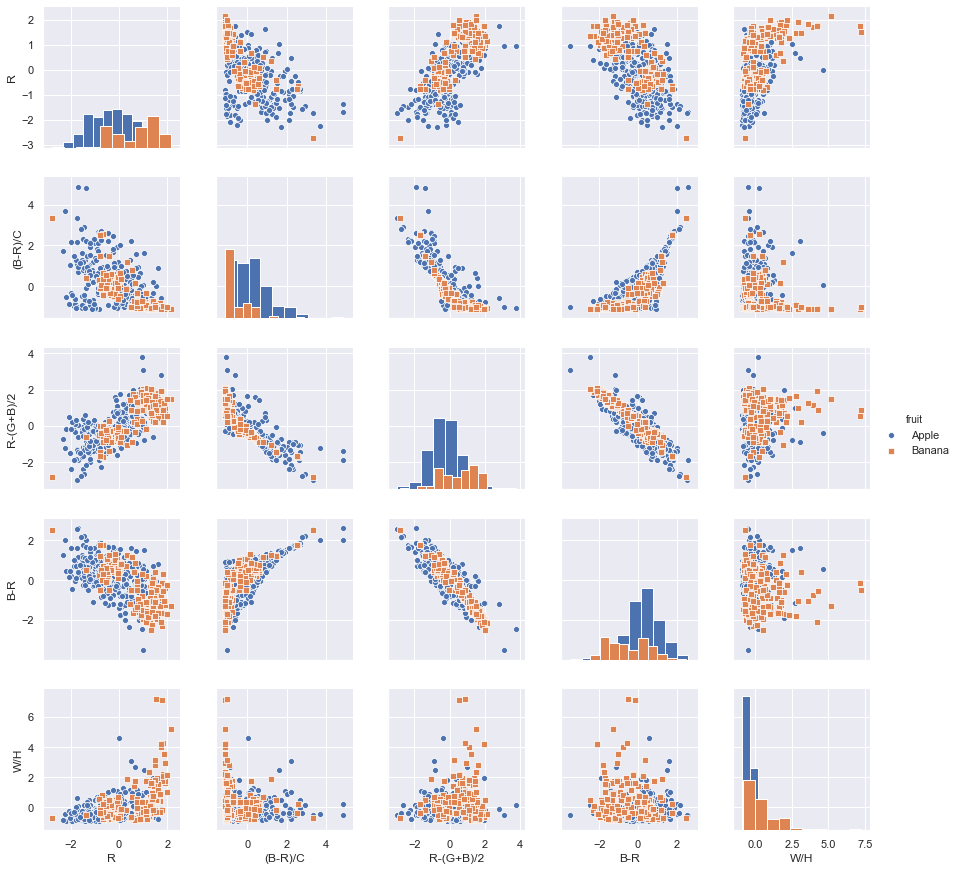

In [22]:
col_selected = ranked_columns[0:5]
df_new = pd.DataFrame.copy(data_df)
df_new = df_new[col_selected]
df_new['fruit'] = fruit_list
g = sns.pairplot(df_new, hue="fruit", markers=["o", "s"], diag_kind="hist")

It is interesting to see how many features are needed to obtain nearly as good performance as with all the features.

In [27]:
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
sklearn_model = KNeighborsClassifier(n_neighbors=3)
feat_lc_df = feature_learning_curve(data_df, sklearn_model, sklearn_metric)

KNEIGHBORSCLASSIFIER
['R' '(B-R)/C' 'R-(G+B)/2' 'B-R' 'W/H' '(R+G+B)/3' 'R-G' 'B-(G+R)/2'
 '(R-G)/C' 'M=maxRGB' '(G-B)/C' 'G' 'H' 'G-B' 'W' 'G-(R+B)/2' 'W*H'
 'C=M-m' 'm=minRGB' 'C/V' 'B']


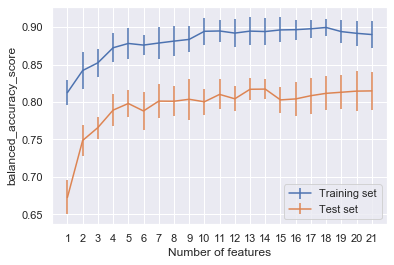

In [28]:
#feat_lc_df[['perf_tr', 'perf_te']].plot()
plt.errorbar(feat_lc_df.index+1, feat_lc_df['perf_tr'], yerr=feat_lc_df['std_tr'], label='Training set')
plt.errorbar(feat_lc_df.index+1, feat_lc_df['perf_te'], yerr=feat_lc_df['std_te'], label='Test set')
plt.xticks(np.arange(1, 22, 1)) 
plt.xlabel('Number of features')
plt.ylabel(sklearn_metric.__name__)
plt.legend(loc='lower right')

We see the, with 5 features, it is about as good as it gets, given the error bars.

We can then investigate all pairs of features among the top 5 to see which pair is best.

In [29]:
range(5)

range(0, 5)

In [30]:
best_perf = -1
std_perf = -1
best_i = 0
best_j = 0
for i in np.arange(5): 
    for j in np.arange(i+1,5): 
        df = data_df[[ranked_columns[i], ranked_columns[j], 'fruit']]
        p_tr, s_tr, p_te, s_te = df_cross_validate(df, sklearn_model, sklearn_metric)
        if p_te > best_perf: 
            best_perf = p_te
            std_perf = s_te
            best_i = i
            best_j = i
            
metric_name = sklearn_metric.__name__.upper()
print('BEST PAIR: {}, {}'.format(best_i, best_j))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te, s_te))

BEST PAIR: 0, 0
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.66 +- 0.03


Not too surprisingly the first two features are best. We can also run a different kind of feature selection, but the results are very similar.

In [31]:
# From https://scikit-learn.org/stable/modules/feature_selection.html
# 1.13.4.2. Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
X = data_df.iloc[:, :-1].to_numpy()
Y = data_df.iloc[:, -1].to_numpy()
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, Y)
ranked_columns = data_df.columns[np.argsort(-clf.feature_importances_)]
print(ranked_columns)

Index(['(B-R)/C', 'R', 'G-(R+B)/2', '(R-G)/C', '(G-B)/C', 'B-R', 'R-(G+B)/2',
       'R-G', 'W/H', 'G', 'G-B', 'W', 'M=maxRGB', '(R+G+B)/3', 'W*H', 'H',
       'm=minRGB', 'B-(G+R)/2', 'C/V', 'C=M-m', 'B'],
      dtype='object')


## Exploring the metadata
For those of you who will chose the project on how to find and correct bias in data, part of your work will be to analyze the metadata: can you predict for example "apple" vs. "banana" based on the meta-features? This would indicate some confounding factor.

In [32]:
metadata = pd.read_csv(os.path.join(data_dir, 'metadata.csv')) #, index_col='Num')
metadata.head()

,Num,File,Subset,Fruit,Color,Count,DateTime,GPSAltitude,GPSLatitude,GPSLongitude>,GPSImgDirection,GPSDestBearing,ShutterSpeedValue,SubsecTimeDigitized,ExposureTime,BrightnessValue
0,1,IMG_3521.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-19 17:39:45,334.0,37;53.7857N,122;15.5356W,356238/1463,356238/1463,84572/17235,944,1/30,5396/1247
1,2,IMG_2818.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-17 08:48:17,327.0,37;53.7943N,122;15.5461W,2224375/16003,2277333/16384,84572/17235,510,1/30,19223/5070
2,3,IMG_4313.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-21 09:36:05,313.0,37;53.7997N,122;15.5736W,352652/1409,352652/1409,49625/8401,213,1/60,59991/11077
3,4,IMG_2819.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-17 08:48:20,327.0,37;53.7943N,122;15.5461W,49647/394,49647/394,84572/17235,72,1/30,159250/38599
4,5,IMG_2953.png,MISC,FRUIT-NA,COLOR-NA,NUM-NA,2019-07-17 09:03:13,330.0,37;53.796N,122;15.5511W,389855/1317,389855/1317,84572/17235,935,1/30,26857/12851


In [33]:
# Select images with a single apple or banana
is_apple  = metadata['Fruit'] == 'APPLE'
is_banana = metadata['Fruit'] == 'BANANA'
count_one = metadata['Count'] == '1-ONE'
apple_subset = metadata[is_apple & count_one]
banana_subset = metadata[is_banana & count_one]
print('Apples: {}'.format(apple_subset.shape))
print('Bananas: {}'.format(banana_subset.shape))

Apples: (333, 16)
Bananas: (158, 16)


In [34]:
# Only two variables are numerical, the others would have to be converted.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html may not be the best solution
# Read also https://www.kaggle.com/c/titanic/discussion/5379
# See also https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder

metadata.describe()

,Num,GPSAltitude,SubsecTimeDigitized
count,1534.000000,1533.000000,1534.000000
mean,767.500000,328.069145,496.718383
std,442.971971,20.513714,290.339883
min,1.000000,49.000000,0.000000
25%,384.250000,329.000000,246.000000
50%,767.500000,330.000000,481.500000
75%,1150.750000,333.000000,758.750000
max,1534.000000,344.000000,996.000000


In [35]:
series = ['Num', 'GPSAltitude', 'SubsecTimeDigitized']
metadata_subset = apple_subset.copy()[series]
metadata_subset = metadata_subset.append(banana_subset.copy()[series])
na = len(apple_subset)
nb = len(banana_subset)
Y = np.append(np.ones([na, 1]), -1*np.ones([nb, 1]))
metadata_subset['fruit'] = Y
print(df.shape)
metadata_subset.head()

(491, 3)


,Num,GPSAltitude,SubsecTimeDigitized,fruit
775,776,334.0,106,1.0
776,777,331.0,178,1.0
777,778,327.0,917,1.0
778,779,328.0,342,1.0
779,780,329.0,252,1.0


In [36]:
# Rappel de la question 2.1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
sklearn_model = KNeighborsClassifier(n_neighbors=1)

In [37]:
naval = check_na(metadata_subset)

     GPSAltitude
895          NaN


In [38]:
metadata_subset[metadata_subset.isna()]=0

In [39]:
#metadata_subset.GPSAltitude[895]=0

In [40]:
check_na(metadata_subset)

Empty DataFrame
Columns: []
Index: []


""


In [41]:
p_tr, s_tr, p_te, s_te = df_cross_validate(metadata_subset, sklearn_model, sklearn_metric, n=10, verbose=False)
metric_name = sklearn_metric.__name__.upper()
print("AVERAGE TRAINING {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_tr, s_tr))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te, s_te))

AVERAGE TRAINING BALANCED_ACCURACY_SCORE +- STD: 1.00 +- 0.00
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.99 +- 0.01


In [42]:
corr = metadata_subset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Num,GPSAltitude,SubsecTimeDigitized,fruit
Num,1,-0.00346052,0.030172,0.677032
GPSAltitude,-0.00346052,1,-0.0647048,-0.104884
SubsecTimeDigitized,0.030172,-0.0647048,1,-0.0142716
fruit,0.677032,-0.104884,-0.0142716,1


## Dimensionality reduction

Rather than doing feature selection, another avenue is to use feature transforms to reduce dimensionality, typically find the "principal directions"(directions of largest variance). This is achieved with SVD (the same algorithm we used last week to find the aspect ratio of an elongated object). There again I used my search engine and typed the keywords "pandas svd". I found a nice tutorial on [this page](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/) and a step-by-step procedure on [this page](https://cmdlinetips.com/2019/05/singular-value-decomposition-svd-in-python/). Can you transform the original data frame into a data frame with only 2 features (the two first principal directions)?

<u>Question 1:</u> Create a dataframe called `df_scaled` containing the standardized columns, except the last one (tip: use `drop` to eliminate the last column).

In [61]:
### BEGIN SOLUTION
df = pd.read_csv(os.path.join(data_dir, 'CS_data.csv'))
df_bare = df.drop(columns=['fruit'])
df_scaled = (df_bare-df_bare.mean())/df_bare.std()
df_scaled.head()
### END SOLUTION

,R,G,B,M=maxRGB,m=minRGB,C=M-m,R-(G+B)/2,G-B,G-(R+B)/2,B-R,...,R-G,(G-B)/C,(B-R)/C,(R-G)/C,(R+G+B)/3,C/V,W,H,W/H,W*H
0,-0.094697,-0.802912,1.418747,-0.891020,1.336466,-1.696950,-0.432637,-1.660362,-1.347004,1.210587,...,0.579199,-2.336012,0.646130,1.179120,0.326008,-1.650431,0.249030,0.065306,-0.126039,-0.032573
1,0.503616,-0.772561,-0.666665,0.183203,-0.913998,0.879247,1.148003,-0.029340,-0.573507,-0.898534,...,1.031343,-0.629588,-0.462186,0.866252,-0.499504,0.938614,0.278258,-0.273339,0.449690,-0.190080
2,0.061006,-1.398826,-2.104806,-0.741563,-2.119769,1.269262,1.765190,0.639794,-0.241299,-1.738912,...,1.189200,-0.096683,-0.983712,0.919732,-1.801489,1.726784,2.273420,1.076728,0.157238,1.436246
3,-1.726425,0.099504,-0.595447,-0.333516,-0.686620,0.349539,-1.302076,0.529659,1.114701,0.760168,...,-1.457199,0.582662,1.098479,-1.379813,-1.107018,0.552259,-0.145793,-0.563028,0.591975,-0.426325
4,-0.060727,1.399374,1.787878,1.139418,1.806535,-0.746776,-1.604870,-0.394783,0.394178,1.483473,...,-1.189423,0.414910,1.919623,-1.962907,1.630251,-0.909639,-1.142907,-1.194313,1.109809,-0.814331


<u>Question 2:</u> Perform a singular value decomposition of `df_scaled` and call the resulting matrices u, s, v.

In [62]:
### BEGIN SOLUTION
u, s, v = np.linalg.svd(df_scaled, full_matrices=True)
print('U {}'.format(u.shape))
print('S {}'.format(s.shape))
print('V {}'.format(v.shape))
### END SOLUTION

U (491, 491)
S (21,)
V (21, 21)


<u>Question 3:</u> Make a scree plot of the eigen values (square of the singular values). Save the plot in file 'svd_scree_plot.png'.

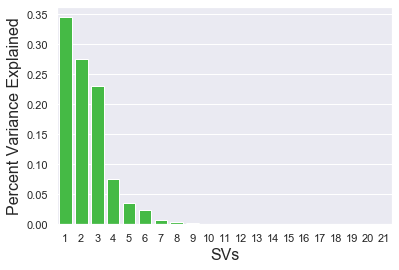

In [63]:
### BEGIN SOLUTION
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen")
plt.xlabel('SVs', fontsize=16)
plt.ylabel('Percent Variance Explained', fontsize=16)
plt.savefig('svd_scree_plot.png',dpi=100)
### END SOLUTION

<u>Question 4:</u> Create a new dataframe `svd_df` with the two singular values as columns and the fruit type as index.

In [64]:
### BEGIN SOLUTION
labels= ['SV'+str(i) for i in range(1,4)]
fruit_name = ['Banana', 'Apple']
fruit_list = [fruit_name[int((i+1)/2)] for i in df["fruit"].tolist()]
svd_df = pd.DataFrame(u[:,0:3], columns=labels)
svd_df['fruit'] = fruit_list
svd_df.head()
### END SOLUTION

,SV1,SV2,SV3,fruit
0,-0.082698,0.020103,0.011550,Apple
1,0.022860,0.032317,0.033502,Apple
2,0.063949,0.088905,-0.001070,Apple
3,0.011986,-0.031958,-0.060016,Apple
4,-0.045156,-0.092459,-0.008405,Apple


<u>Question 5:</u> Make pairwise scatter plots of the three first singular values.

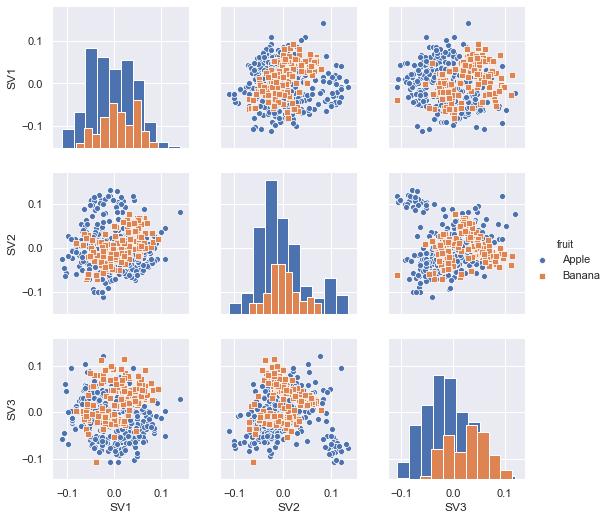

In [65]:
### BEGIN SOLUTION
g = sns.pairplot(svd_df, hue="fruit", markers=["o", "s"], diag_kind="hist")
### END SOLUTION

<u>Question 6:</u> Compute the performances obtained with the 3 nearest neighbor method using the first 3 singular values.

In [66]:
### BEGIN SOLUTION
svd_df['fruit'] = df.iloc[:, -1].to_numpy()
p_tr, s_tr, p_te, s_te = df_cross_validate(svd_df, sklearn_model, sklearn_metric)
metric_name = sklearn_metric.__name__.upper()
print("AVERAGE TRAINING {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_tr, s_tr))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te, s_te))
### END SOLUTION

AVERAGE TRAINING BALANCED_ACCURACY_SCORE +- STD: 1.00 +- 0.00
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.74 +- 0.02
